# Get data

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [2]:
names = open("names.txt").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

# Create dataset

In [3]:
context = 3

In [4]:
import pdb

ds = []
for name in names:
    n = '.'*context + name + '.'
    tuples = list(zip(*list(n[i:] for i in range(context + 1))))
    ds.extend(list(map(lambda tup: (tup[0:context], tup[context]), tuples)))

ds[:15]

[(('.', '.', '.'), 'e'),
 (('.', '.', 'e'), 'm'),
 (('.', 'e', 'm'), 'm'),
 (('e', 'm', 'm'), 'a'),
 (('m', 'm', 'a'), '.'),
 (('.', '.', '.'), 'o'),
 (('.', '.', 'o'), 'l'),
 (('.', 'o', 'l'), 'i'),
 (('o', 'l', 'i'), 'v'),
 (('l', 'i', 'v'), 'i'),
 (('i', 'v', 'i'), 'a'),
 (('v', 'i', 'a'), '.'),
 (('.', '.', '.'), 'a'),
 (('.', '.', 'a'), 'v'),
 (('.', 'a', 'v'), 'a')]

# Vocab

In [42]:
vocab = sorted(set('.'.join(names)))
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [43]:
ctoi = {c: i for i, c in enumerate(vocab)}
itoc = {i: c for c, i in ctoi.items() }

# Embedding

In [196]:
emb_dims = 2
E = torch.randn(len(vocab), emb_dims)
E.shape

torch.Size([27, 2])

In [197]:
E[:, 0].shape, E[:, 1].shape

(torch.Size([27]), torch.Size([27]))

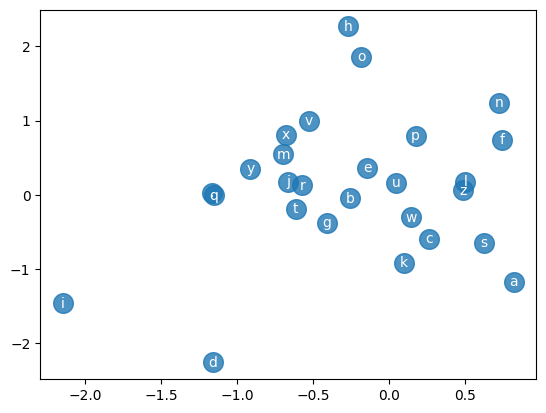

In [198]:
plt.scatter(E[:, 0], E[:, 1], s=200, alpha=0.8)

for char in vocab:
    i = ctoi[char]
    plt.text(E[i, 0], E[i, 1], char, va="center", ha="center", color="white")

In [199]:
ids = torch.zeros(len(ds), context + 1, dtype=torch.int)
for i, (x, y) in enumerate(ds):
    ids[i, 0:context] = torch.tensor(list(map(lambda c: ctoi[c],x)))
    ids[i, context] = ctoi[y]

ids[:10]

tensor([[ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        [ 5, 13, 13,  1],
        [13, 13,  1,  0],
        [ 0,  0,  0, 15],
        [ 0,  0, 15, 12],
        [ 0, 15, 12,  9],
        [15, 12,  9, 22],
        [12,  9, 22,  9]], dtype=torch.int32)

In [210]:
E.requires_grad_()

nh = 100
Wh = torch.randn(context*emb_dims, nh, requires_grad=True)
Bh = torch.randn(nh, requires_grad=True)

no = len(vocab)
Wo = torch.randn(nh, no, requires_grad=True)
Bo = torch.randn(no, requires_grad=True)

params = [E, Wh, Bh, Wo, Bo]

In [251]:
ids

tensor([[ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        ...,
        [26, 26, 25, 26],
        [26, 25, 26, 24],
        [25, 26, 24,  0]], dtype=torch.int32)

In [264]:
import torch.nn.functional as F

In [272]:
ods = F.one_hot(ids.long(), 27)
ods.shape

torch.Size([228146, 4, 27])

In [548]:
ntr = int(len(ods) * 0.8)
nval = int(len(ods) * 0.9)
idx = torch.randint(0, len(ods), (len(ods),))

tr_ds = ods[idx[:ntr]]
val_ds = ods[idx[ntr:nval]]
test_ds = ods[idx[nval:]]

assert sum(list(map(len, [tr_ds, val_ds, test_ds]))) == len(ods)

In [551]:
def get_batches(bs, ds):
    b = ds[torch.randint(0, len(ds), size=(bs,))].float()

    xb = b[:, 0:context]
    yb = b[:, context]

    return xb, yb

In [552]:
def forward(bs, xb):
    ae = (xb @ E).view(bs, -1)
    ah = (ae @ Wh + Bh).tanh()
    ao = ah @ Wo + Bo
    
    return ao

In [553]:
def optimize():
    for param in params:
        param.data -= param.grad * 0.001
        param.grad = None

In [557]:
bs = 64

for i in range(10000):
    # Train
    xb, yb = get_batches(bs, tr_ds)
    z = forward(bs, xb)
    tr_loss = F.cross_entropy(z, yb)
    tr_loss.backward()
    optimize()

    # Eval
    xb, yb = get_batches(bs, val_ds)
    with torch.no_grad(): 
        z = forward(bs, xb)
        val_loss = F.cross_entropy(z, yb)
    
    # Report
    if i % 1000 == 0: print(f"Tr: {tr_loss:.2f} | Val: {val_loss:.2f}")
    


Tr: 2.63 | Val: 2.04
Tr: 2.39 | Val: 2.28
Tr: 2.28 | Val: 2.80
Tr: 2.51 | Val: 2.15
Tr: 2.31 | Val: 2.23
Tr: 2.22 | Val: 2.22
Tr: 2.31 | Val: 2.27
Tr: 2.33 | Val: 2.19
Tr: 2.26 | Val: 2.05
Tr: 1.86 | Val: 2.32


In [561]:
bs = len(test_ds)
x_test, y_test = get_batches(bs, test_ds)

print(f"Test loss is {F.cross_entropy(forward(bs, x_test), y_test):.2f}")

Test loss is 2.27


In [246]:
"""
Run each char through the embedding
Get 6 numbers
Run through the hidden layer, e.g. 100 neurons
Activate hidden layer by tanh
Run through the output layer
"""

'\nRun each char through the embedding\nGet 6 numbers\nRun through the hidden layer, e.g. 100 neurons\nActivate hidden layer by tanh\nRun through the output layer\n'

In [89]:
list(zip(*b['x'][:10]))

[('.', '.', 'i', 'n', 'o', '.', '.', '.', '.', 'h'),
 ('.', '.', 'e', 'e', 'r', 'c', 's', 'a', 't', 'a'),
 ('.', 'c', 'l', 'l', 't', 'h', 'h', 'a', 'r', 'a')]